In [157]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm


print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]
PyTorch version 2.5.1+cpu
Torchvision version 0.20.1+cpu
Numpy version 2.1.2
Pandas version 2.2.3


In [158]:
import os
import glob
import numpy as np
from torch.utils.data import Dataset
import torch
from PIL import Image

class PlayingCardRawDataset(Dataset):
    def __init__(self, data_dir, width, height, transform=None):
        self.data_dir = data_dir
        self.width = width
        self.height = height
        self.transform = transform

        # Get all .raw files and assume subfolder names are labels
        self.samples = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        for cls in self.classes:
            class_folder = os.path.join(data_dir, cls)
            raw_files = glob.glob(os.path.join(class_folder, "*.raw"))
            for path in raw_files:
                self.samples.append((path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        with open(path, 'rb') as f:
            raw_data = np.frombuffer(f.read(), dtype=np.uint8)
            image = raw_data.reshape((self.height, self.width))
            image = Image.fromarray(image, mode='L')  # <-- Add this line

        if self.transform:
            image = self.transform(image)

        return image, label

    @property
    def class_names(self):
        return self.classes


## Create Test Dataset

In [159]:
dataset = PlayingCardRawDataset(
    data_dir=r'C:\Users\jobri\ML\JOBY_TRAINING\train',
    width=128,
    height=128,
    transform=None  # or a torchvision transform if needed
)


In [161]:
len(dataset)

3357

In [162]:
image, label = dataset[800]
print(label)
image

import matplotlib.pyplot as plt

# plt.imshow(image.squeeze(), cmap='gray')  # squeeze() removes the extra channel dim
# plt.title(f"Label: {label}")
# plt.axis('off')
# plt.show()


1


In [163]:
# Get a dictionary associating target values with folder names
data_dir = r'C:\Users\jobri\ML\JOBY_TRAINING\train'
target_to_class = {v: k for k, v in dataset.class_to_idx.items()}
print(target_to_class)


{0: '10_S', 1: '7_D', 2: 'A_H', 3: 'K_C'}


In [164]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = PlayingCardRawDataset(
    data_dir=r'C:\Users\jobri\ML\JOBY_TRAINING\train',
    width=128,
    height=128,
    transform=transform
)


In [165]:
image, label = dataset[100]
image.shape

torch.Size([1, 128, 128])

In [166]:
# iterate over dataset
for image, label in dataset:
    break

## Dataloaders

In [167]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [168]:
for images, labels in dataloader:
    break

In [169]:
images.shape, labels.shape

(torch.Size([32, 1, 128, 128]), torch.Size([32]))

In [170]:
labels

tensor([3, 1, 2, 0, 1, 1, 3, 2, 3, 1, 0, 1, 3, 0, 1, 2, 3, 2, 2, 3, 2, 3, 1, 1,
        2, 1, 2, 1, 1, 1, 2, 1])

# Pytorch Model

In [171]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=4
    ):
        super(SimpleCardClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output


In [172]:
model = SimpleCardClassifer(num_classes=4)
print(str(model)[:500])

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal


In [173]:
if images.shape[1] == 1:
    images = images.repeat(1, 3, 1, 1)


In [174]:
example_out = model(images)

example_out.shape # [batch_size, num_classes]

torch.Size([32, 4])

# The training loop

In [175]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [176]:
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 4]) torch.Size([32])


## Setup Datasets

In [177]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = r'C:\Users\jobri\ML\JOBY_TRAINING\train'
valid_folder = r'C:\Users\jobri\ML\JOBY_TRAINING\valid'
test_folder = r'C:\Users\jobri\ML\JOBY_TRAINING\test'

width = 128
height = 128

train_dataset = PlayingCardRawDataset(train_folder, width=width, height=height, transform=transform)
val_dataset   = PlayingCardRawDataset(valid_folder, width=width, height=height, transform=transform)
test_dataset  = PlayingCardRawDataset(test_folder, width=width, height=height, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Simple Training Loop

In [178]:
from tqdm import tqdm

# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=4)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Add progress bar for epochs
for epoch in tqdm(range(num_epochs), desc='Epochs'):
    # Training phase
    model.train()
    running_loss = 0.0
    
    # Use regular tqdm for batch progress
    train_pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}', leave=False)
    for images, labels in train_pbar:
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)

        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        
        # Update progress bar with current loss
        train_pbar.set_postfix({'loss': loss.item()})
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f'Validation Epoch {epoch+1}', leave=False)
        for images, labels in val_pbar:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
            if images.shape[1] == 1:
                images = images.repeat(1, 3, 1, 1)

         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            
            # Update progress bar with current loss
            val_pbar.set_postfix({'loss': loss.item()})
            
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")

Epochs:  20%|██        | 1/5 [01:26<05:46, 86.72s/it]

Epoch 1/5 - Train loss: 0.1076, Validation loss: 0.0829


Epochs:  40%|████      | 2/5 [03:00<04:31, 90.60s/it]

Epoch 2/5 - Train loss: 0.0145, Validation loss: 0.1418


Epochs:  60%|██████    | 3/5 [04:35<03:05, 92.94s/it]

Epoch 3/5 - Train loss: 0.0178, Validation loss: 0.0737


Epochs:  80%|████████  | 4/5 [06:09<01:33, 93.44s/it]

Epoch 4/5 - Train loss: 0.0047, Validation loss: 0.2867


Epochs: 100%|██████████| 5/5 [07:48<00:00, 93.61s/it]

Epoch 5/5 - Train loss: 0.0143, Validation loss: 0.0379


# Visualize Losses

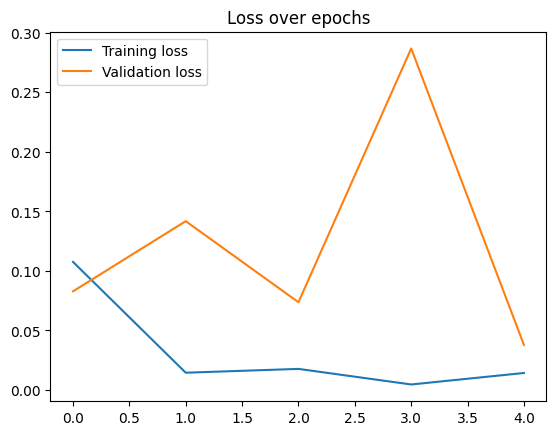

In [179]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [180]:
print("Probabilities shape:", probabilities.shape)
print("Class names:", class_names)


Probabilities shape: (4,)
Class names: ['10_S', '7_D', 'A_H', 'K_C']


# Evaluating the Results

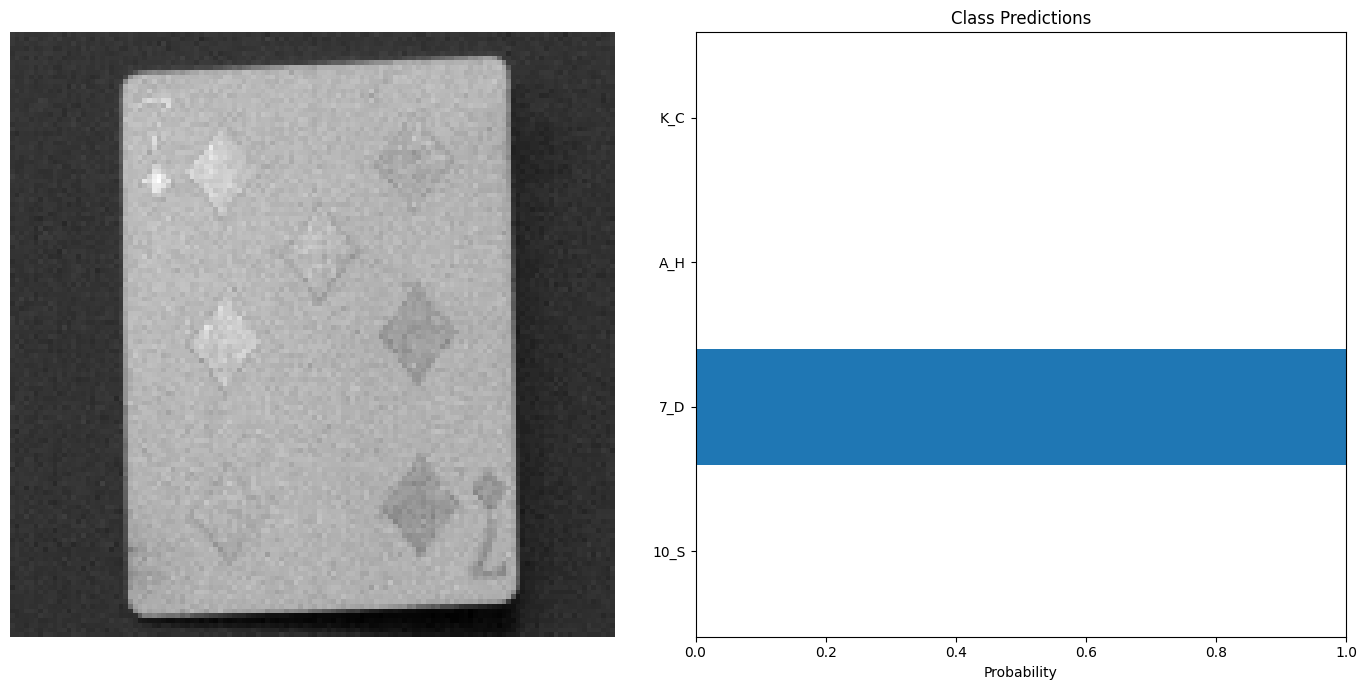

In [181]:
# import torch
# import torchvision.transforms as transforms
# from PIL import Image
# import matplotlib.pyplot as plt
# import numpy as np

# # Load and preprocess the image
# def preprocess_image(image_path, transform):
#     image = Image.open(image_path).convert("RGB")
#     return image, transform(image).unsqueeze(0)

# # Predict using the model
# def predict(model, image_tensor, device):
#     model.eval()
#     with torch.no_grad():
#         image_tensor = image_tensor.to(device)
#         outputs = model(image_tensor)
#         probabilities = torch.nn.functional.softmax(outputs, dim=1)
#     return probabilities.cpu().numpy().flatten()

# # Visualization
# def visualize_predictions(original_image, probabilities, class_names):
#     fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
#     # Display image
#     axarr[0].imshow(original_image)
#     axarr[0].axis("off")
    
#     # Display predictions
#     axarr[1].barh(class_names, probabilities)
#     axarr[1].set_xlabel("Probability")
#     axarr[1].set_title("Class Predictions")
#     axarr[1].set_xlim(0, 1)

#     plt.tight_layout()
#     plt.show()

# # Example usage
# test_image = r"C:\Users\jobri\ML\card_raw\test\7_D\7_D.0015.raw"
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor()
# ])

# original_image, image_tensor = preprocess_image(test_image, transform)
# probabilities = predict(model, image_tensor, device)

# # Assuming dataset.classes gives the class names
# class_names = dataset.classes 
# visualize_predictions(original_image, probabilities, class_names)

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# Load and preprocess a .raw image file
def preprocess_raw_image(raw_path, width, height, transform):
    with open(raw_path, 'rb') as f:
        raw_data = np.frombuffer(f.read(), dtype=np.uint8)
        image_array = raw_data.reshape((height, width))
        pil_image = Image.fromarray(image_array, mode='L')  # grayscale image
    return pil_image, transform(pil_image).unsqueeze(0)  # keep original PIL for display

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        if image_tensor.shape[1] == 1:
            image_tensor = image_tensor.repeat(1, 3, 1, 1)  # fake RGB if needed
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    axarr[0].imshow(original_image, cmap='gray')  # grayscale image
    axarr[0].axis("off")
    
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# === Example usage ===

test_image_path = r"C:\Users\jobri\ML\JOBY_TRAINING\train\7_D\7_D.0014.raw"
width = 128
height = 128

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load, predict, visualize
original_image, image_tensor = preprocess_raw_image(test_image_path, width, height, transform)
probabilities = predict(model, image_tensor, device)

# Get class names from your dataset
class_names = dataset.class_names

visualize_predictions(original_image, probabilities, class_names)


Using pip 24.2 from C:\Users\jobri\miniconda3\Lib\site-packages\pip (python 3.12)


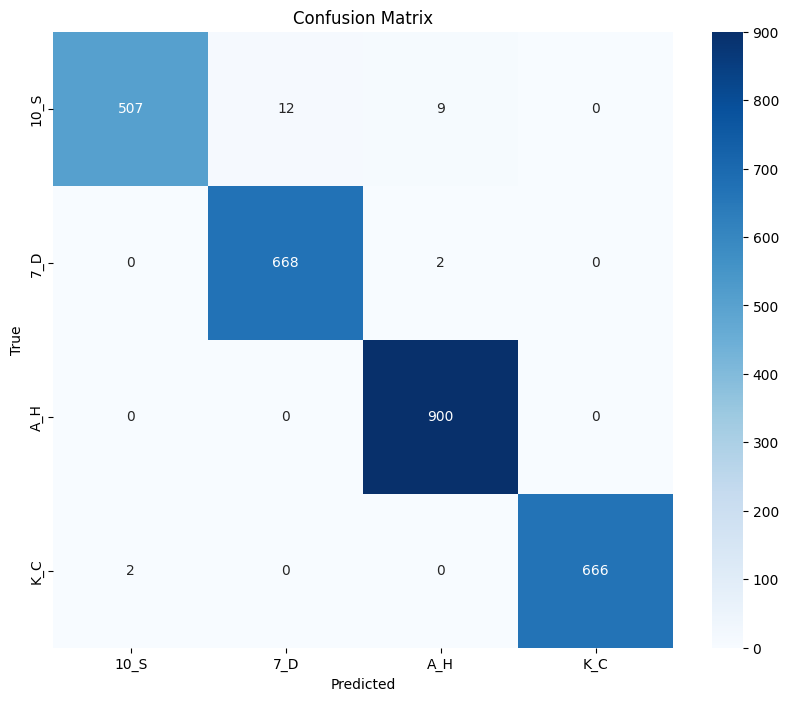

In [182]:
!pip install -U scikit-learn --verbose
!pip install seaborn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Evaluate on the test dataset
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)
            
        # Get predictions
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Store predictions and true labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(dataset.classes))))

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



In [142]:
from sklearn.metrics import accuracy_score

# Calculate overall average accuracy
def calculate_accuracy(loader, model, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # 🔧 Repeat grayscale channel to simulate RGB if needed
            if images.shape[1] == 1:
                images = images.repeat(1, 3, 1, 1)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Calculate and print average accuracy on training and validation sets
train_accuracy = calculate_accuracy(train_loader, model, device)
val_accuracy = calculate_accuracy(val_loader, model, device)

print(f'Overall Training Accuracy: {train_accuracy:.4f}')
print(f'Overall Validation Accuracy: {val_accuracy:.4f}')



Overall Training Accuracy: 0.9997
Overall Validation Accuracy: 0.9524


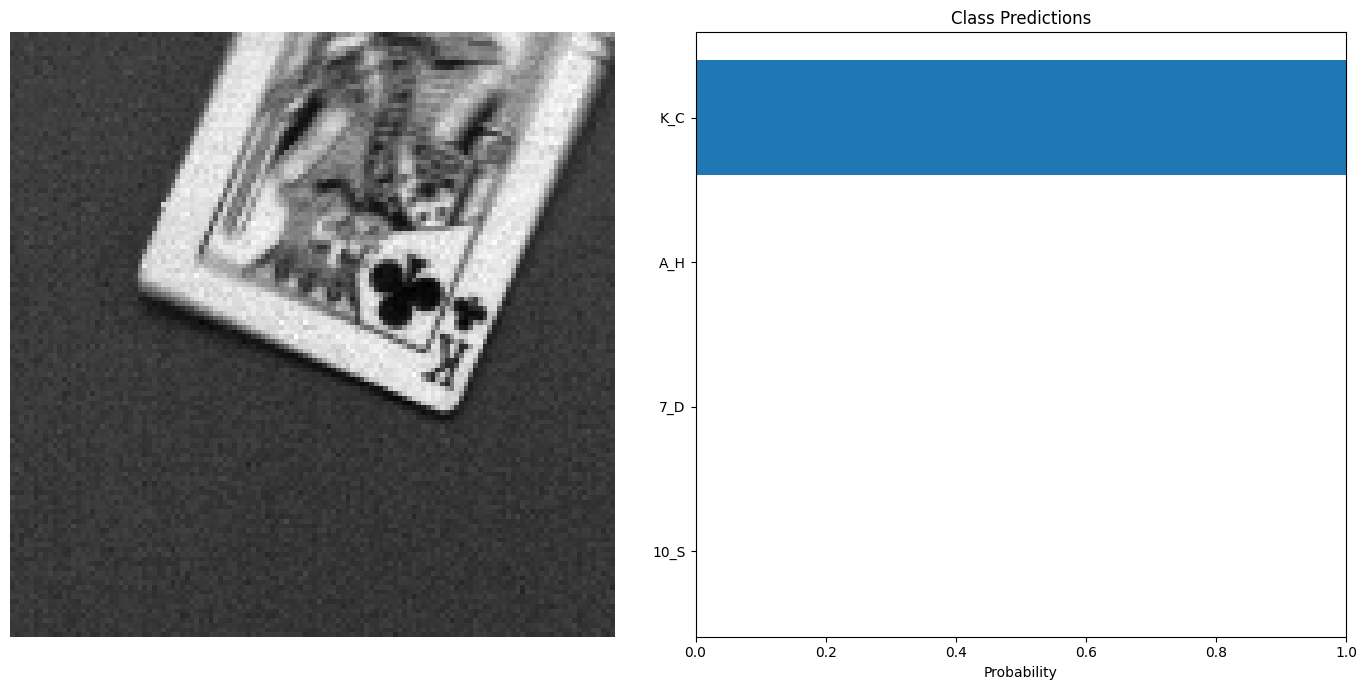

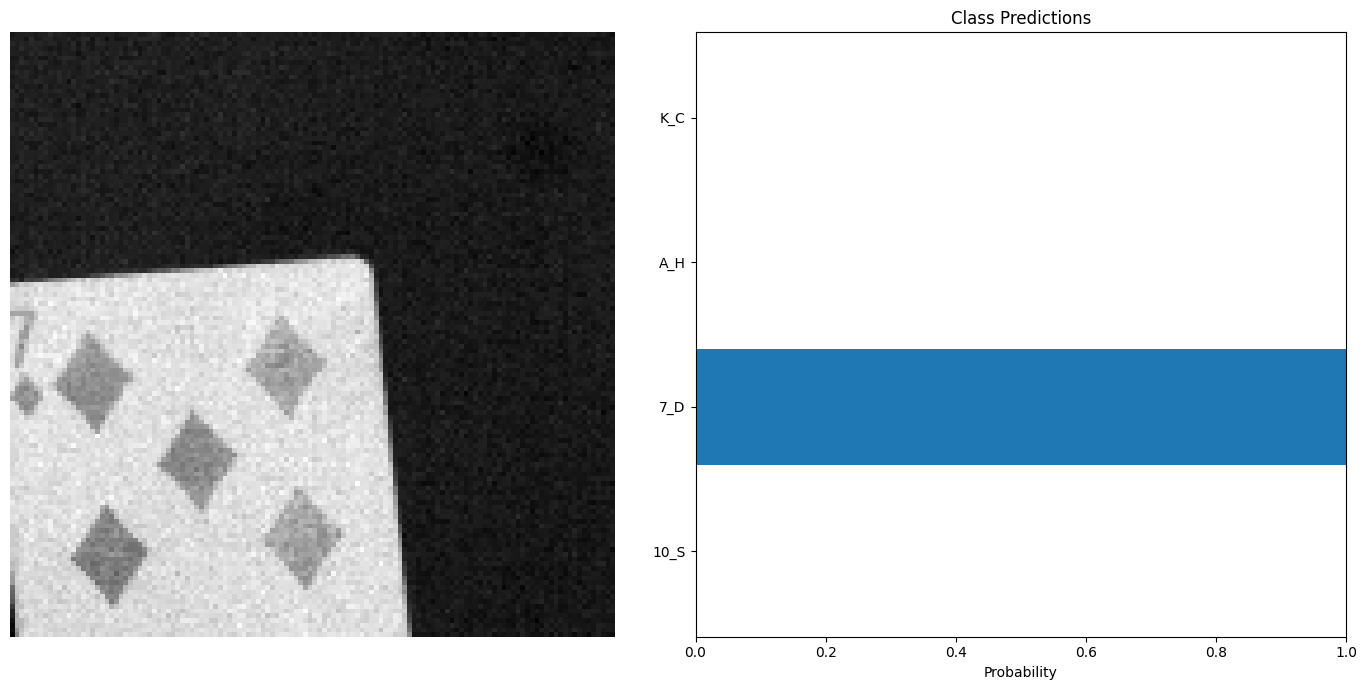

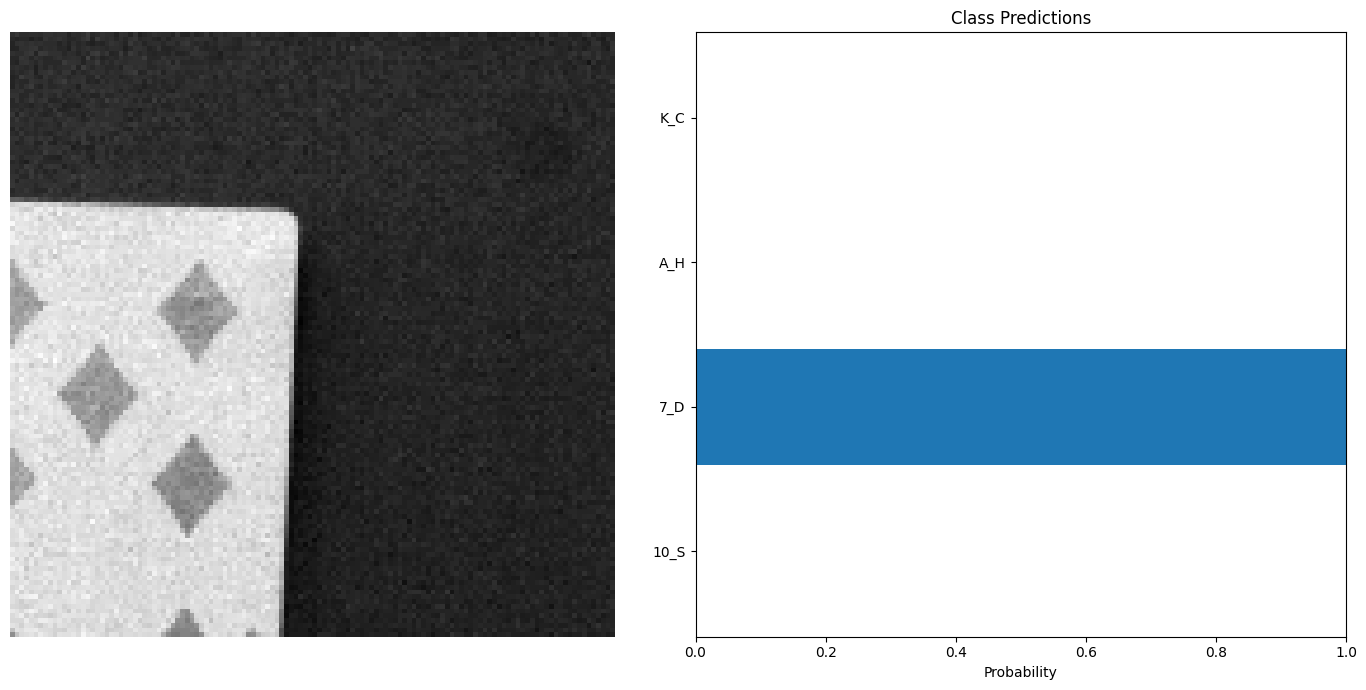

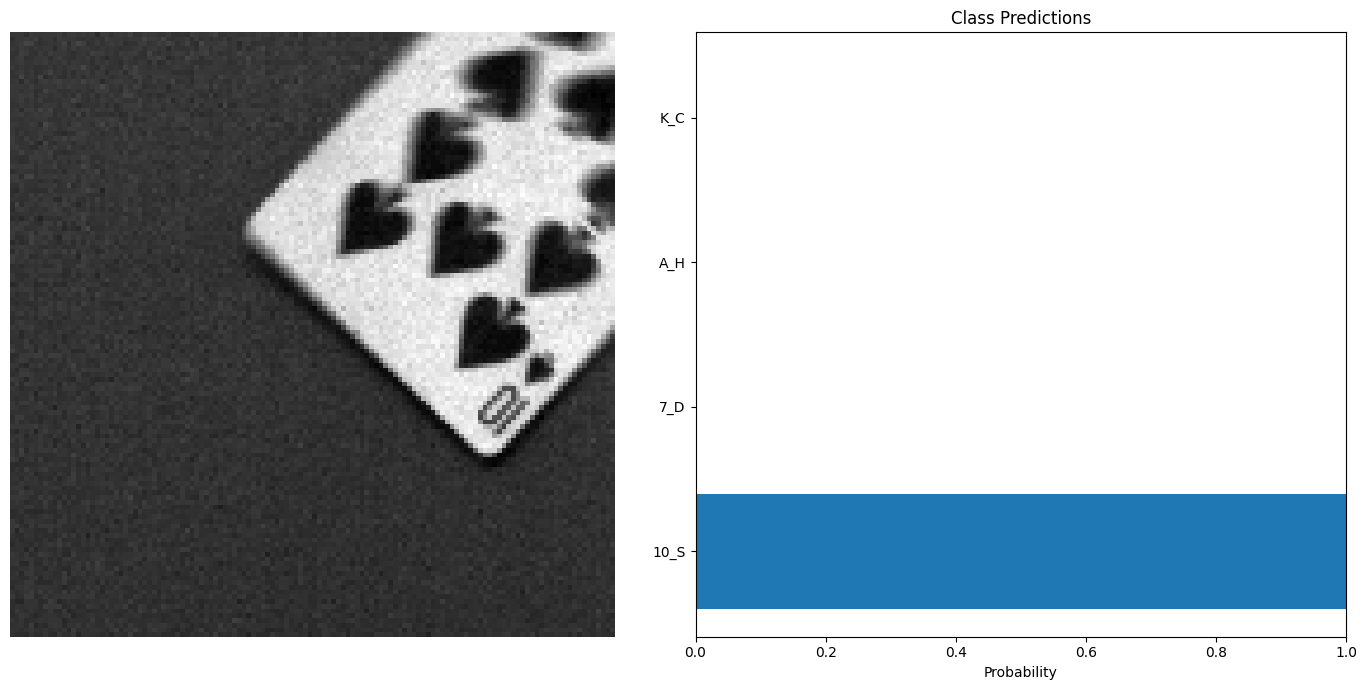

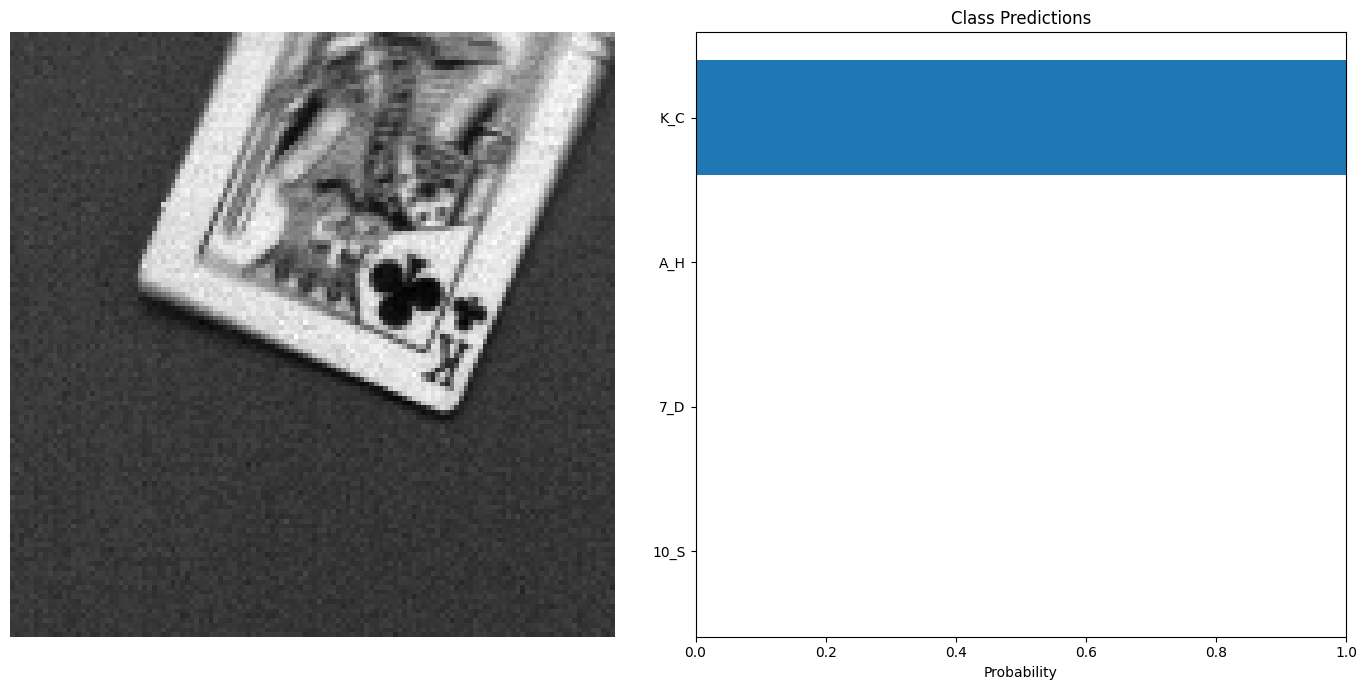

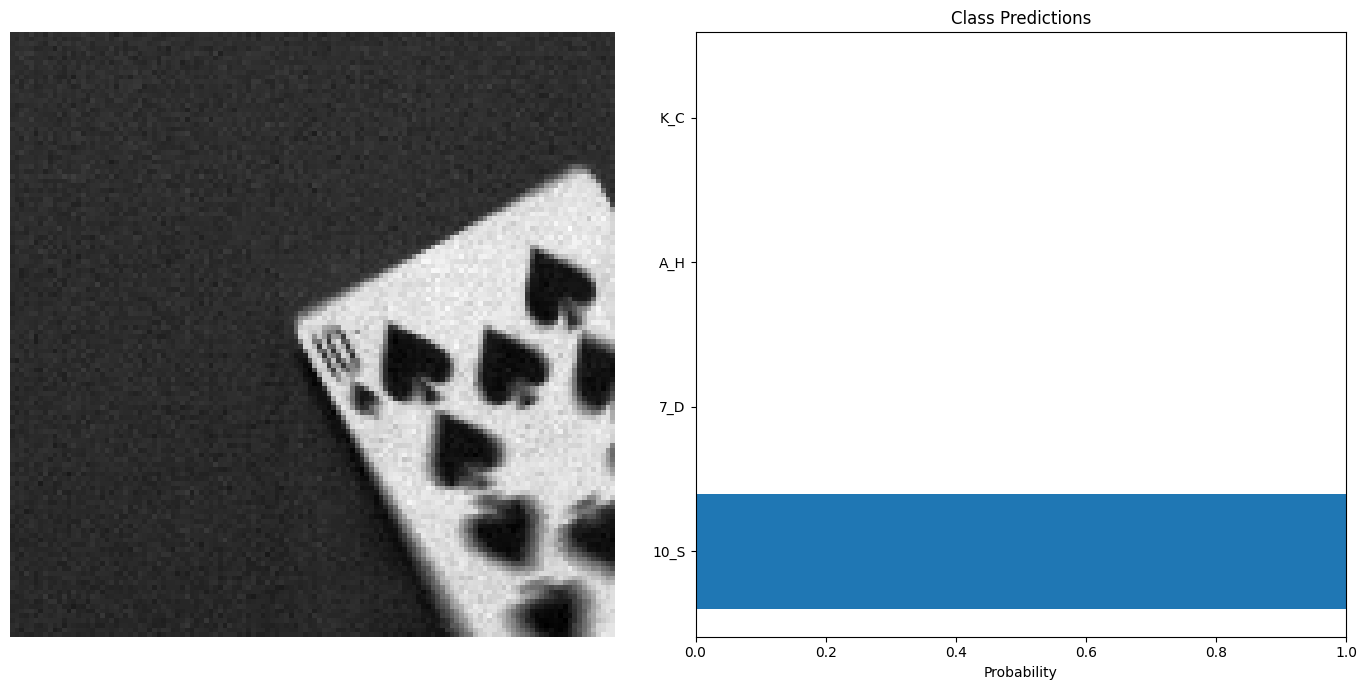

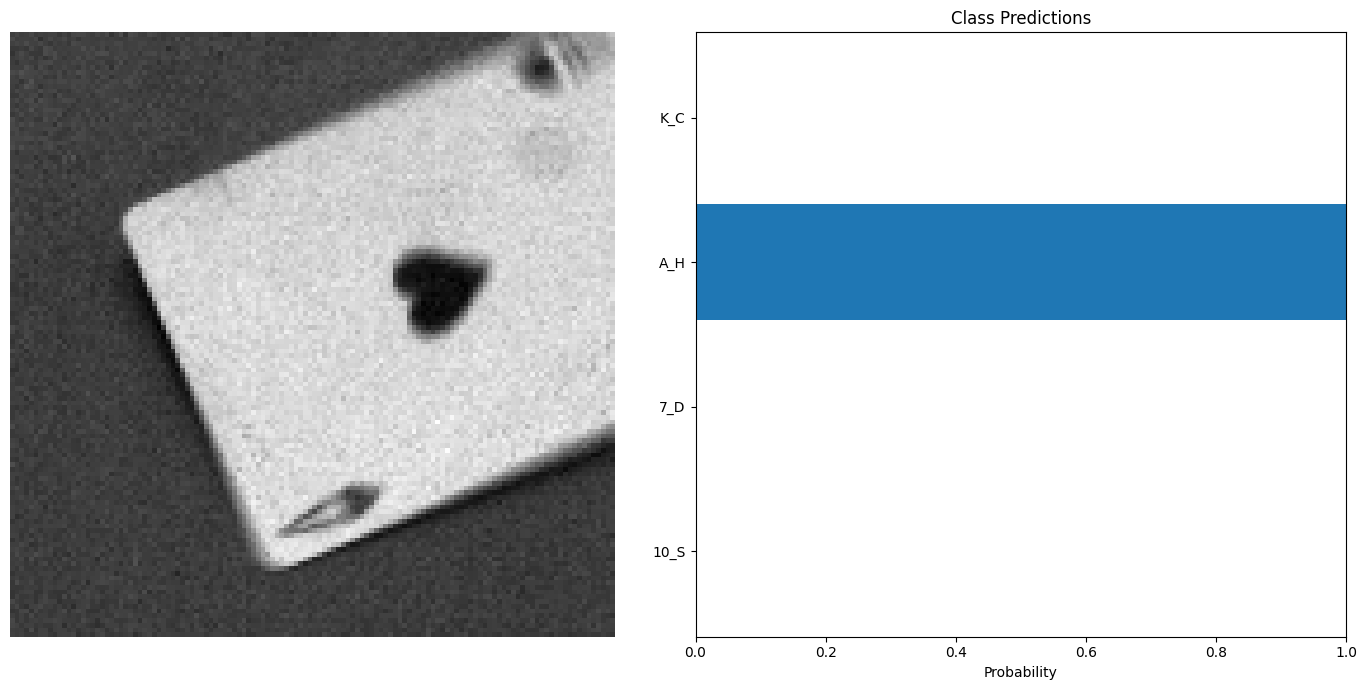

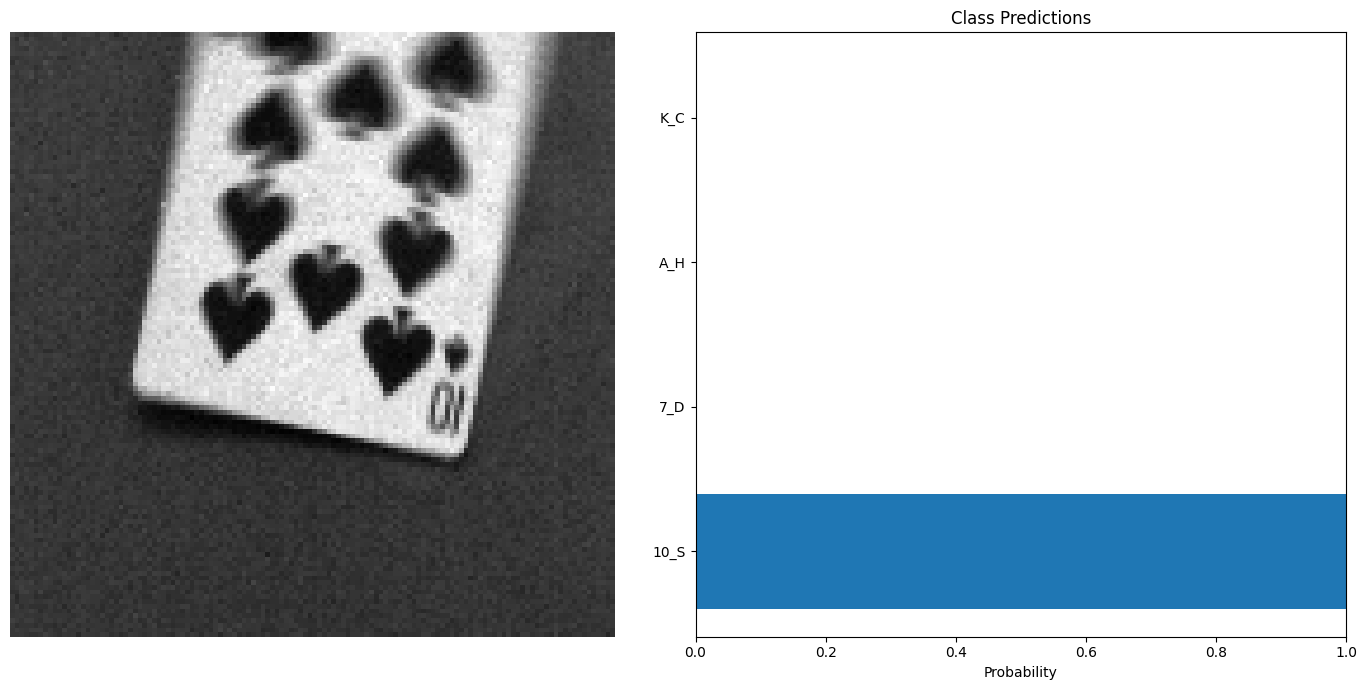

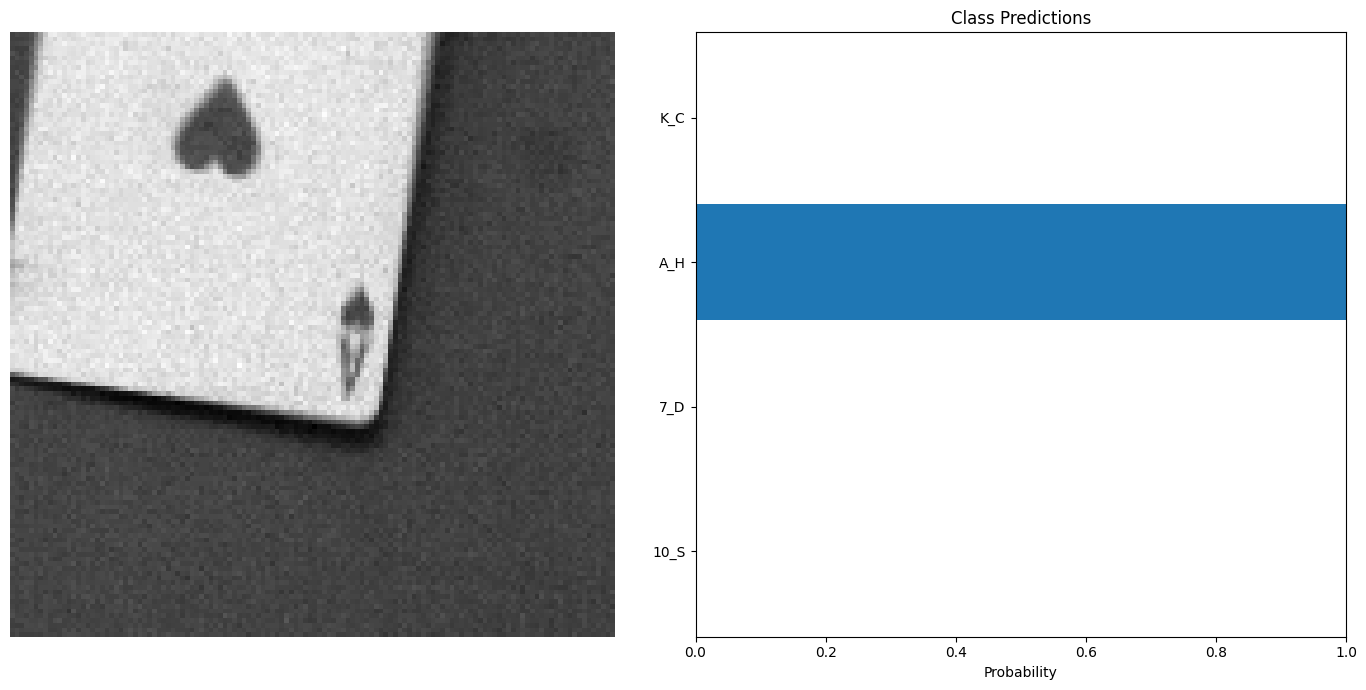

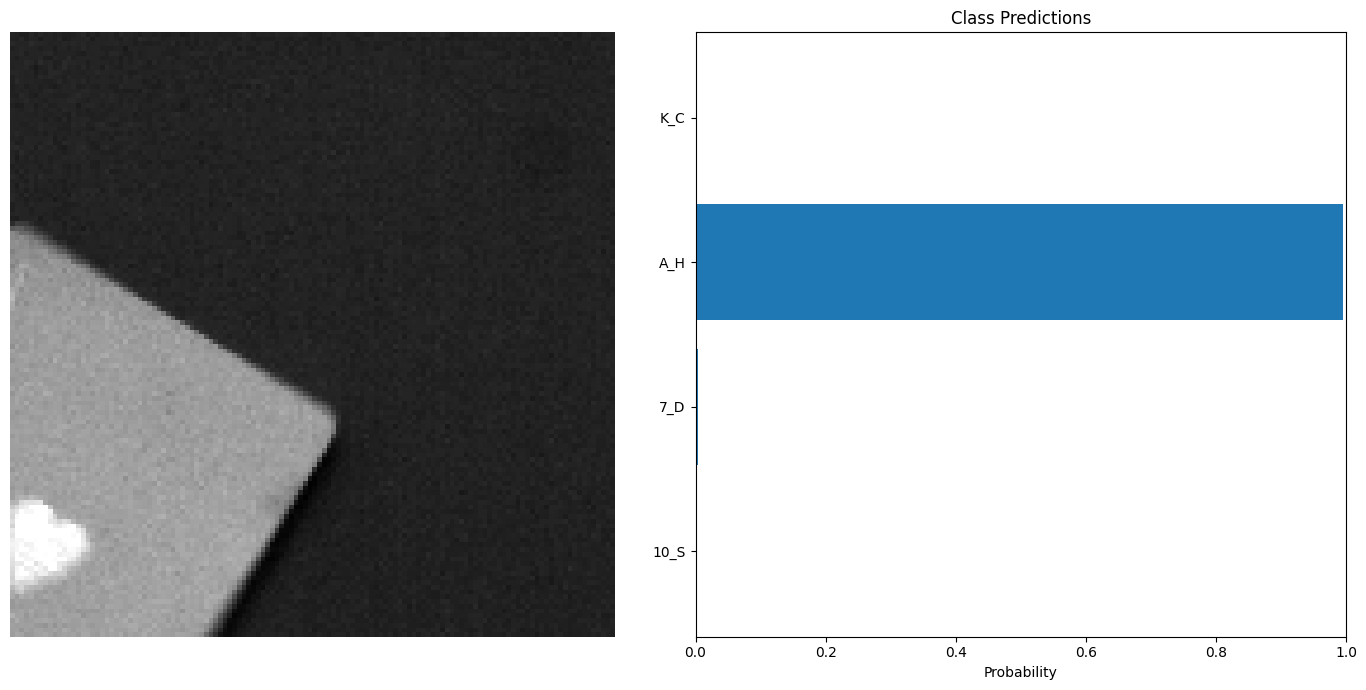

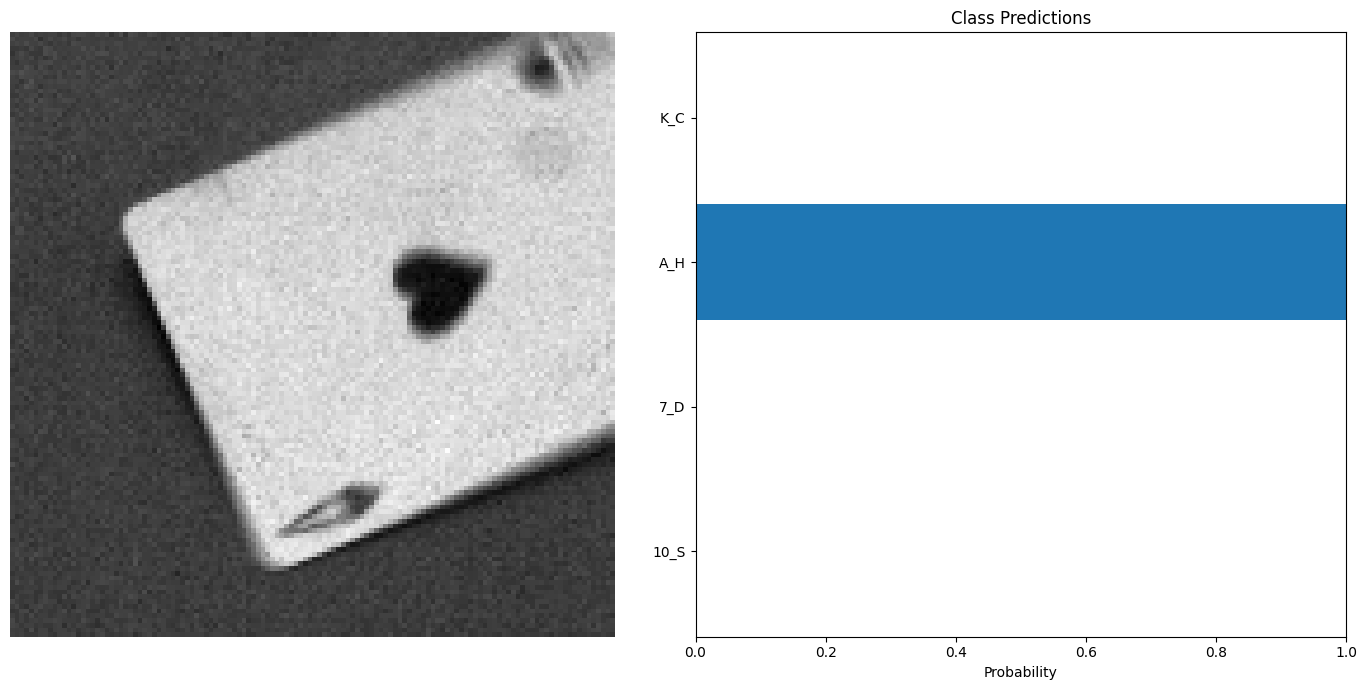

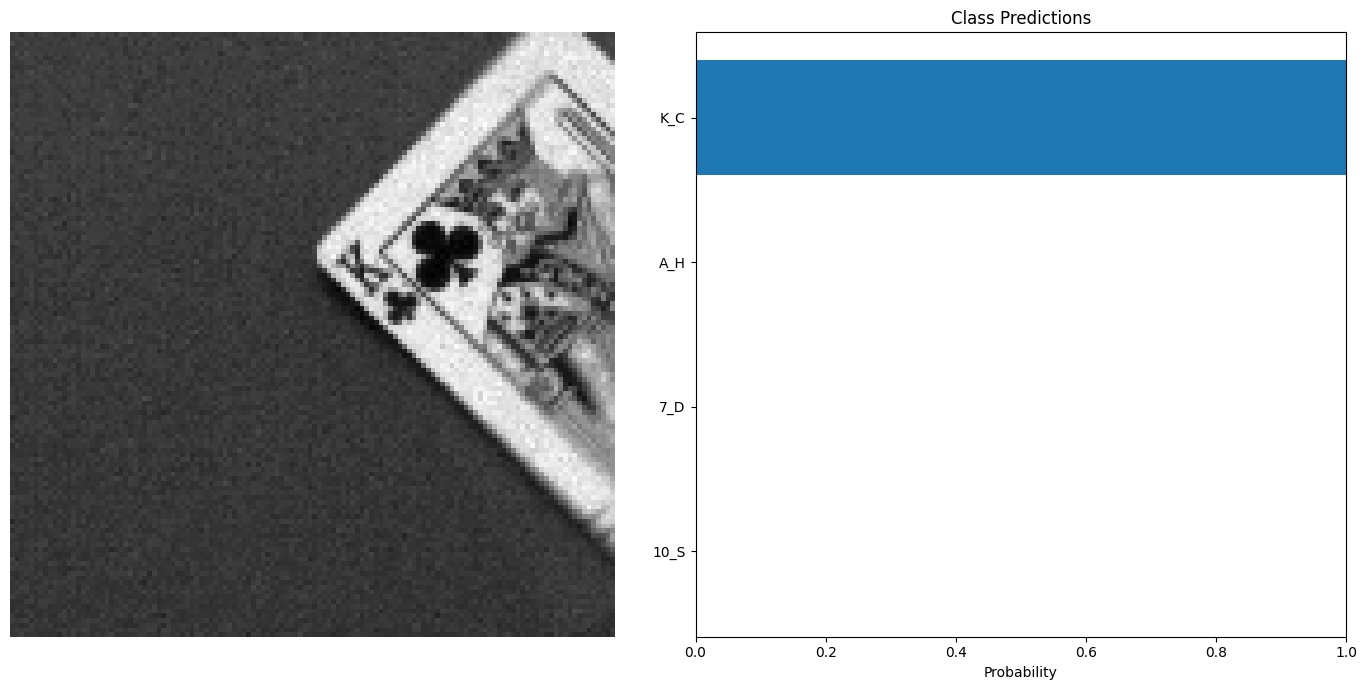

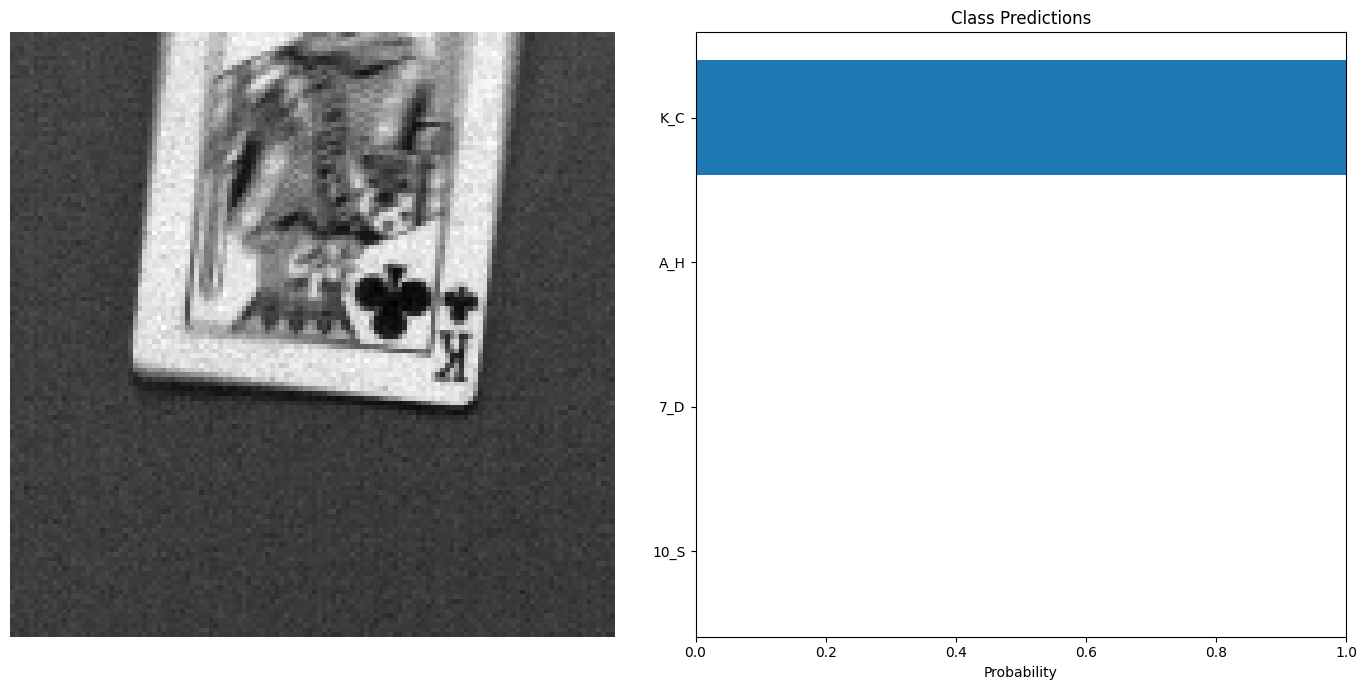

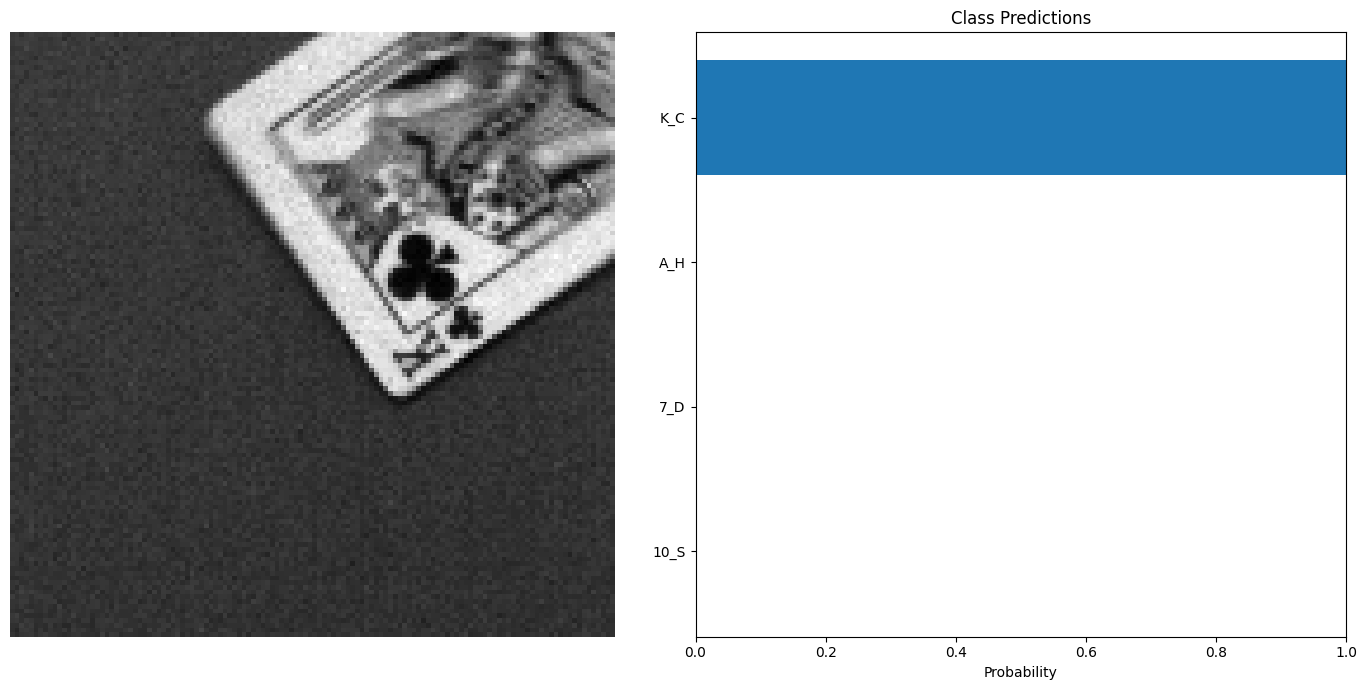

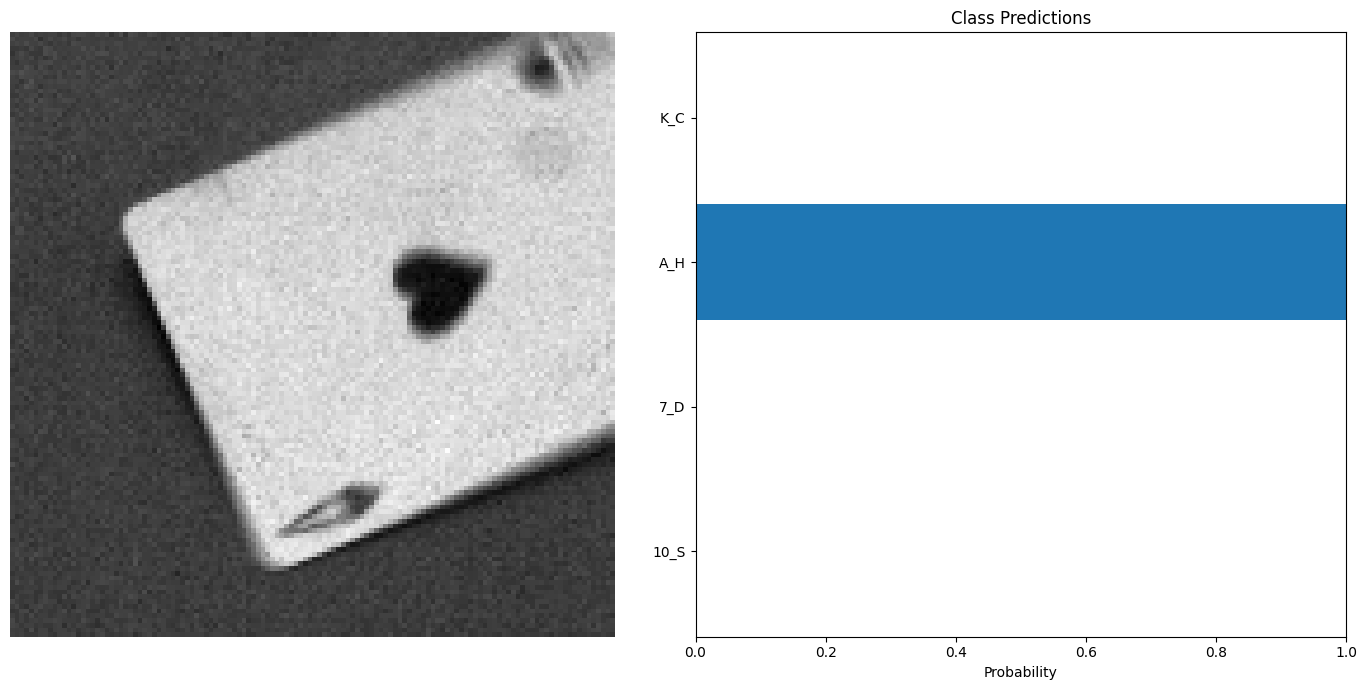

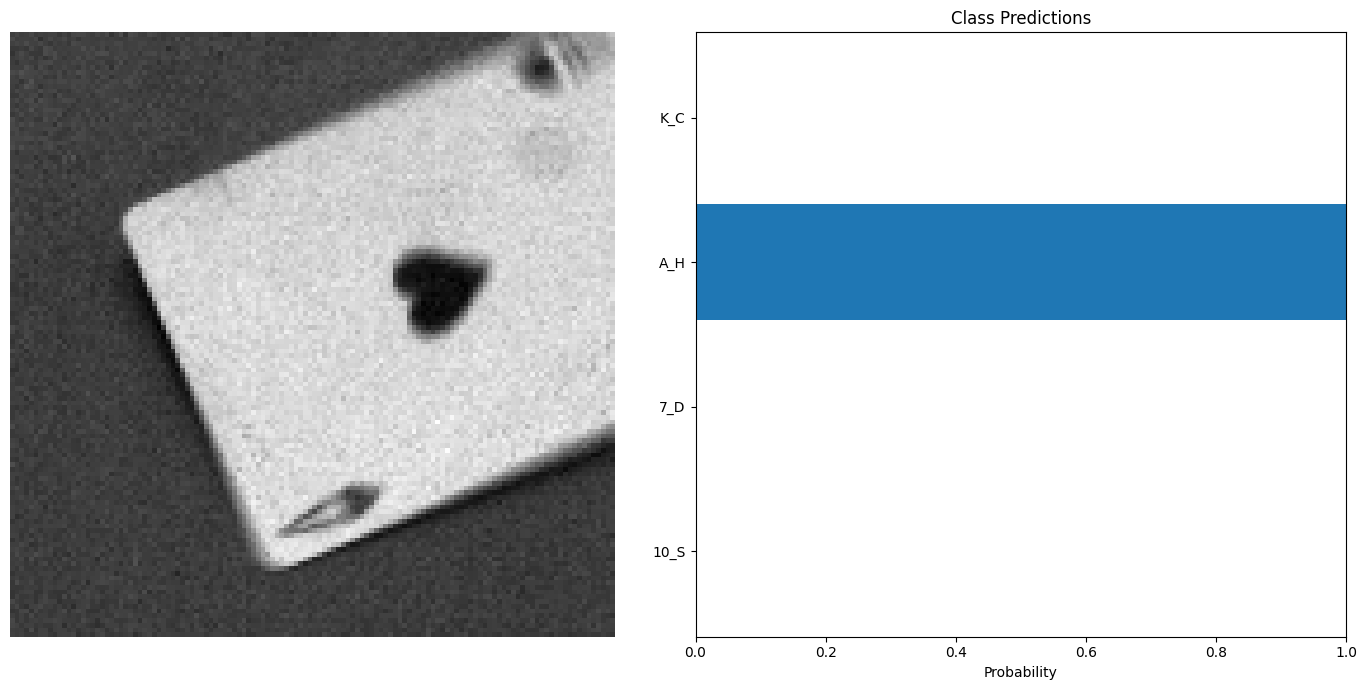

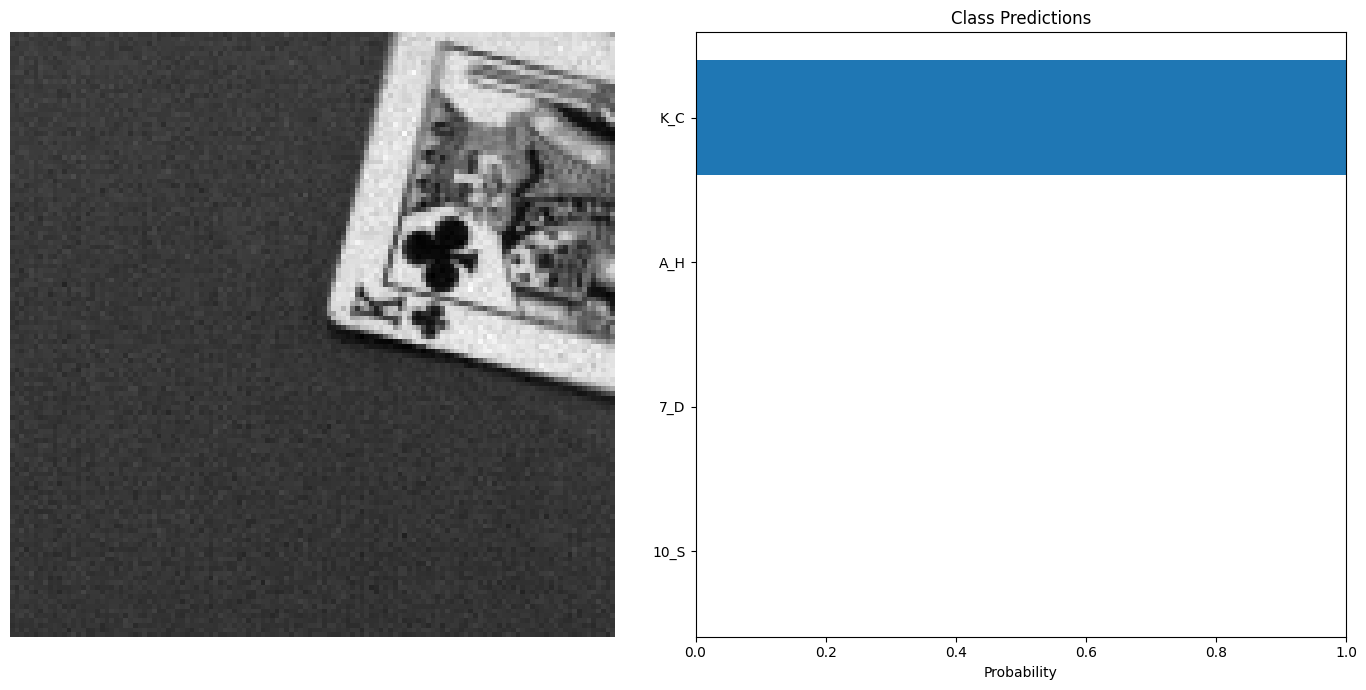

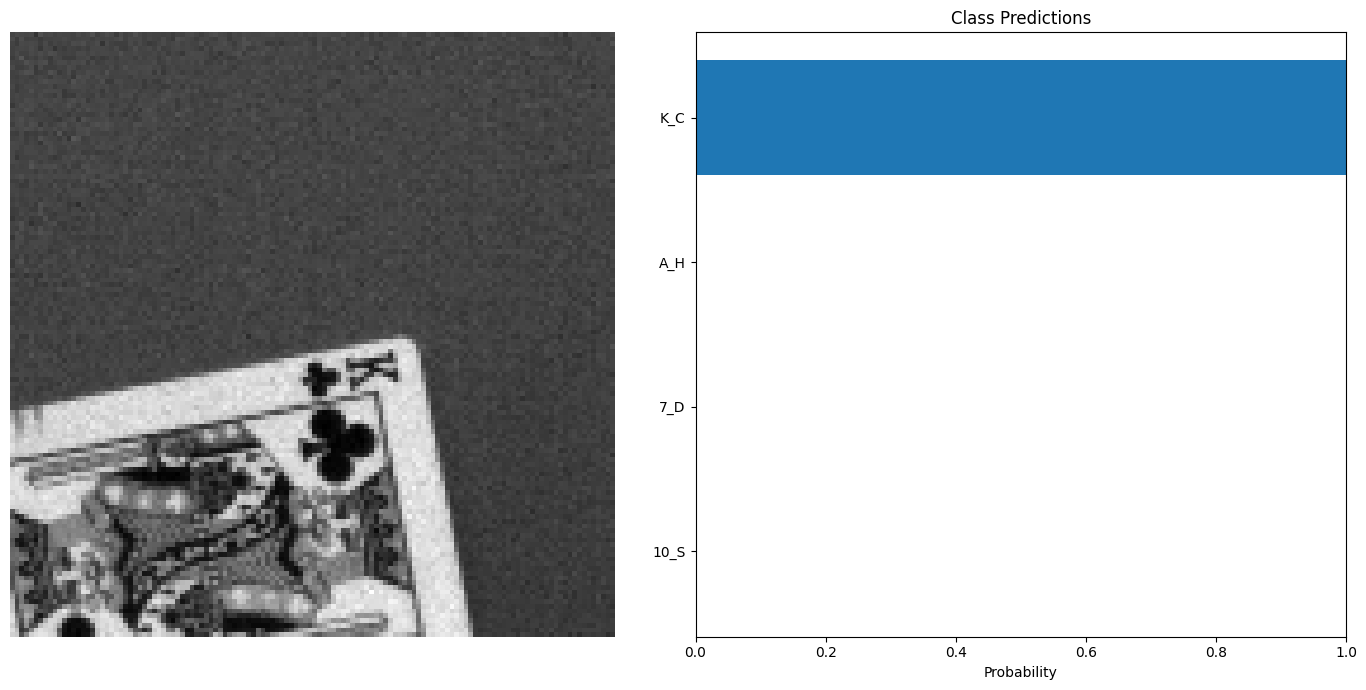

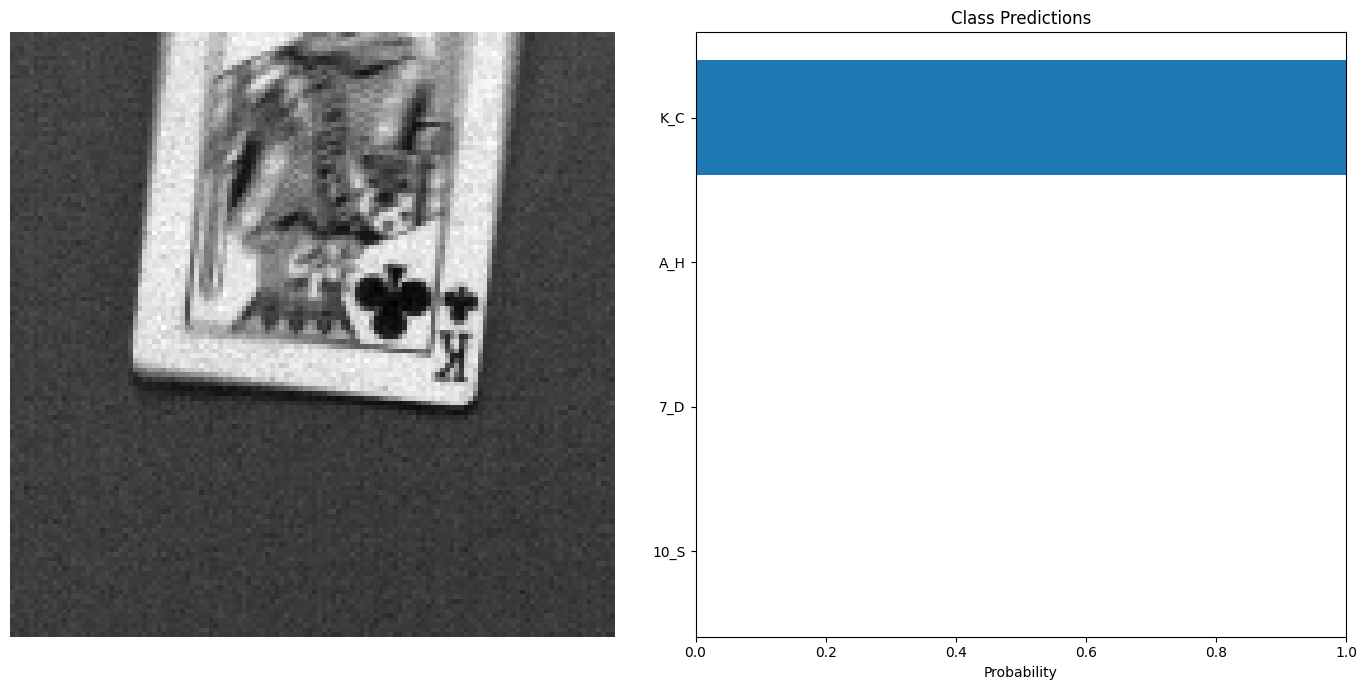

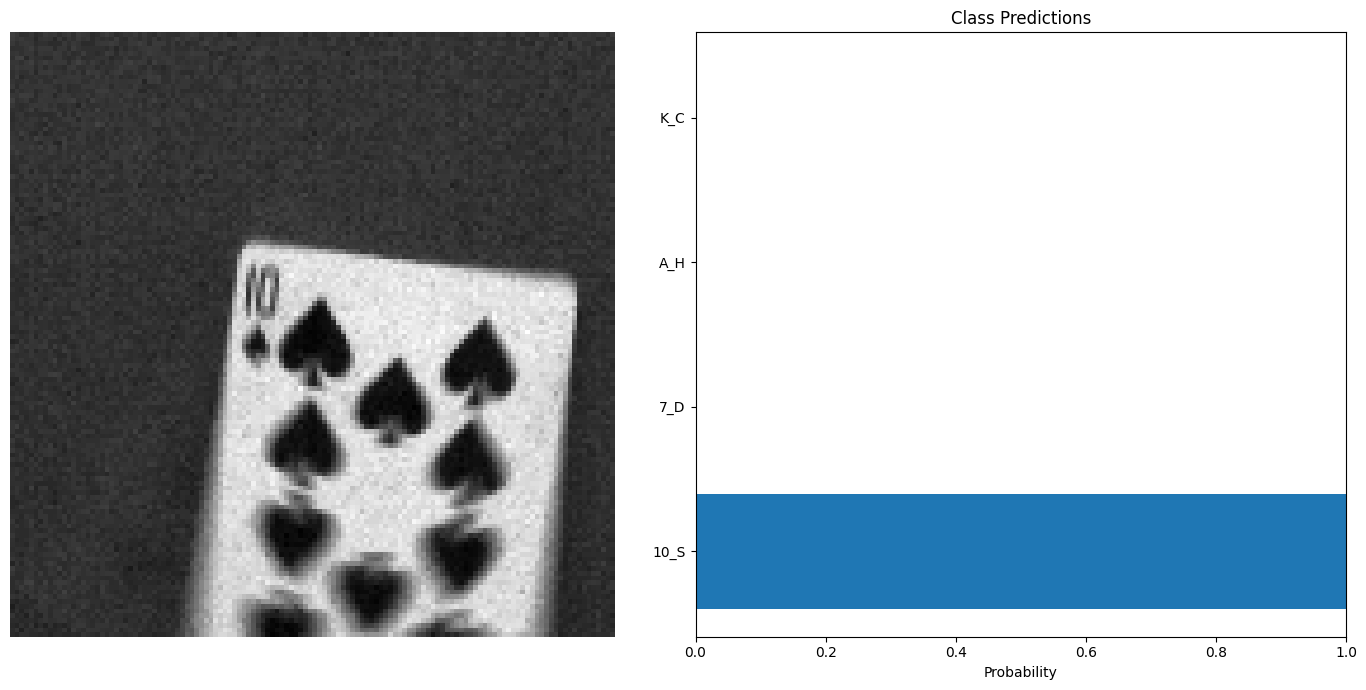

In [183]:
from glob import glob
test_images = glob(r'C:\Users\jobri\ML\JOBY_TRAINING\test/*/*')
test_examples = np.random.choice(test_images, 20)

for example in test_examples:
    original_image, image_tensor = preprocess_raw_image(example, width=128, height=128, transform=transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

In [146]:
from glob import glob
test_images = glob(r'C:\Users\jobri\ML\JOBY_TRAINING\test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

UnidentifiedImageError: cannot identify image file 'C:\\Users\\jobri\\ML\\JOBY_TRAINING\\test\\K_C\\K_C.508.raw'

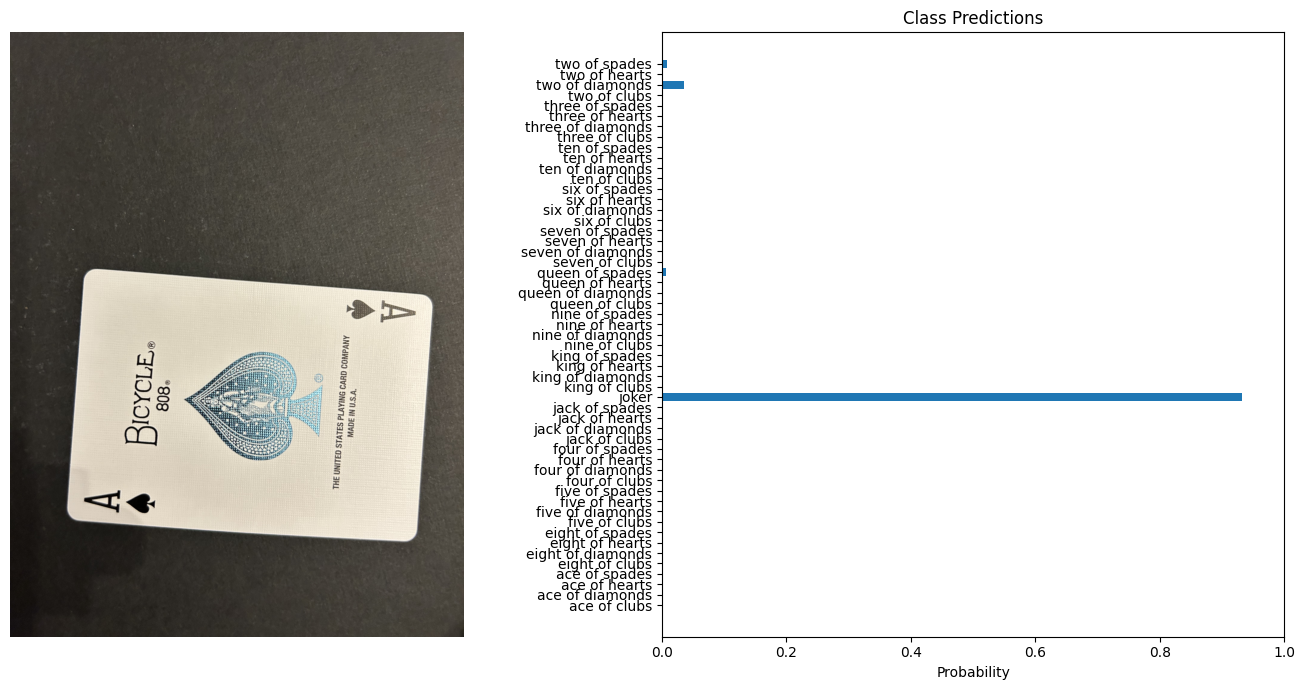

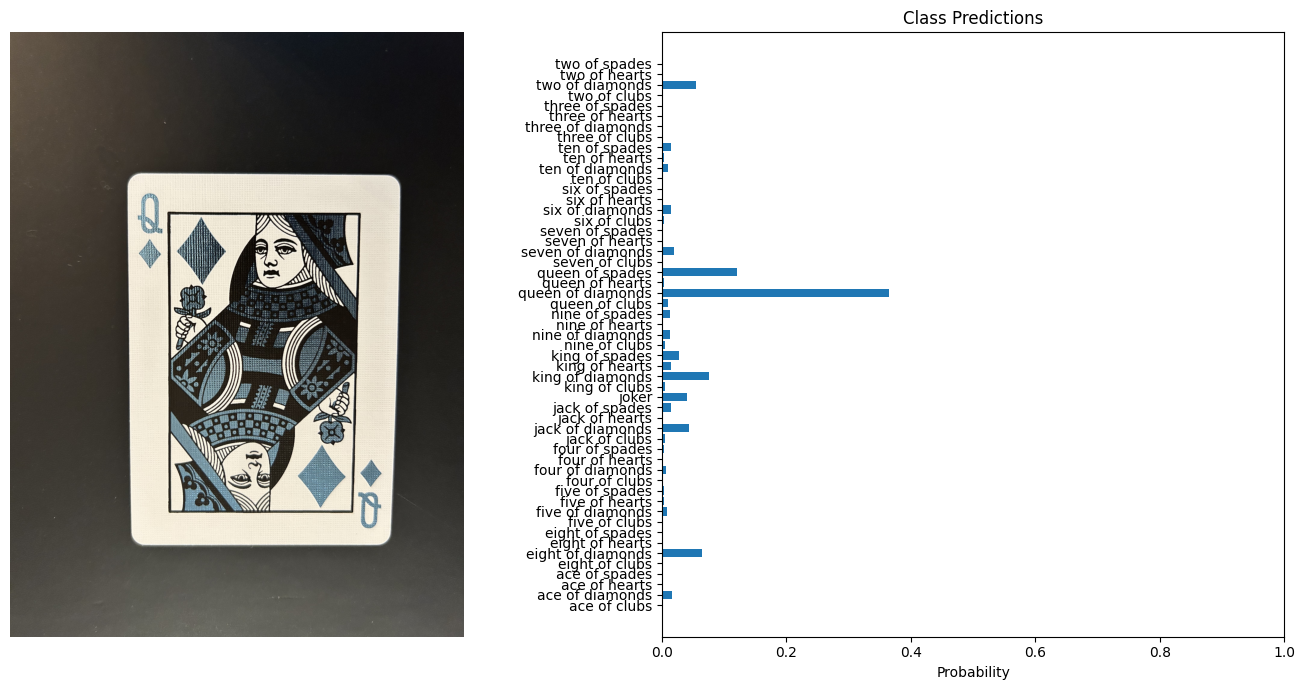

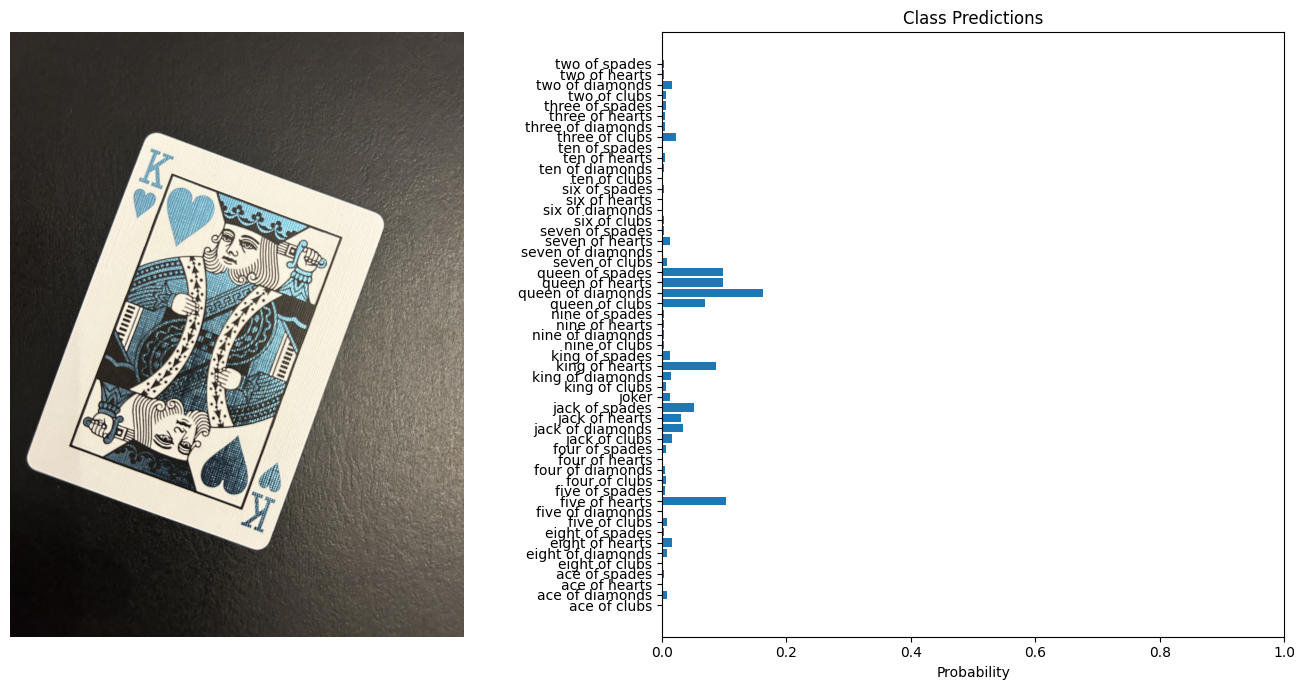

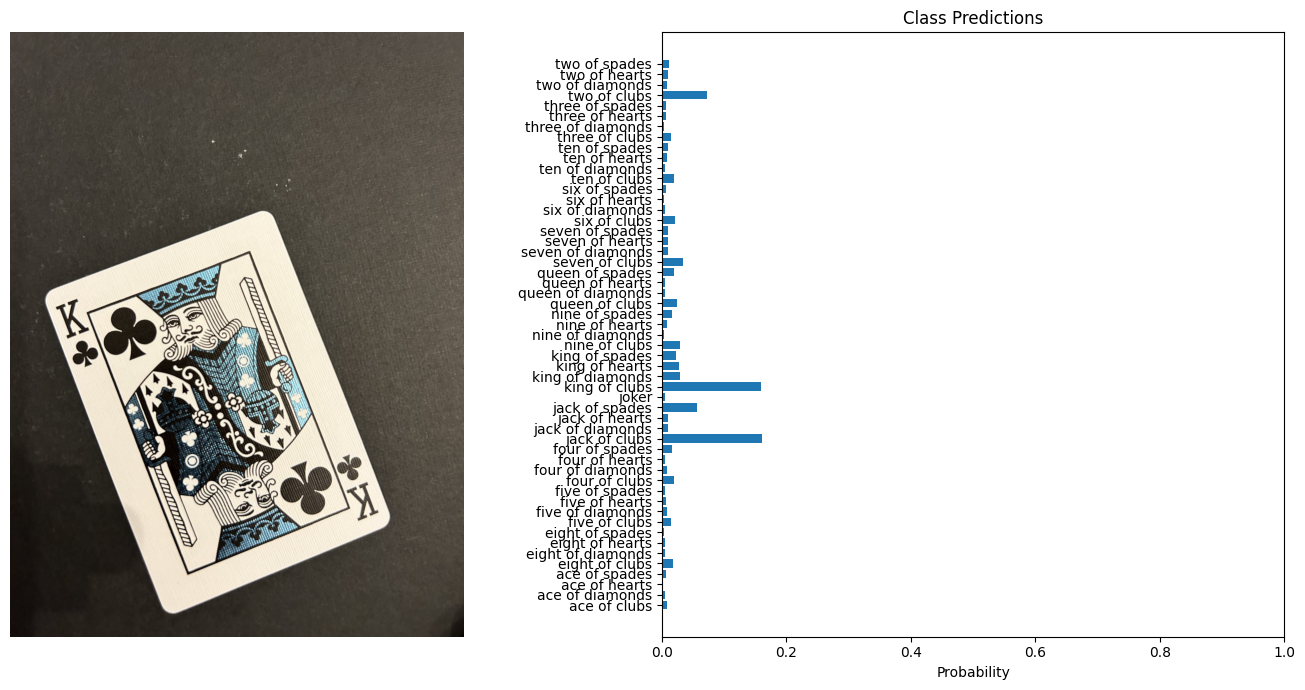

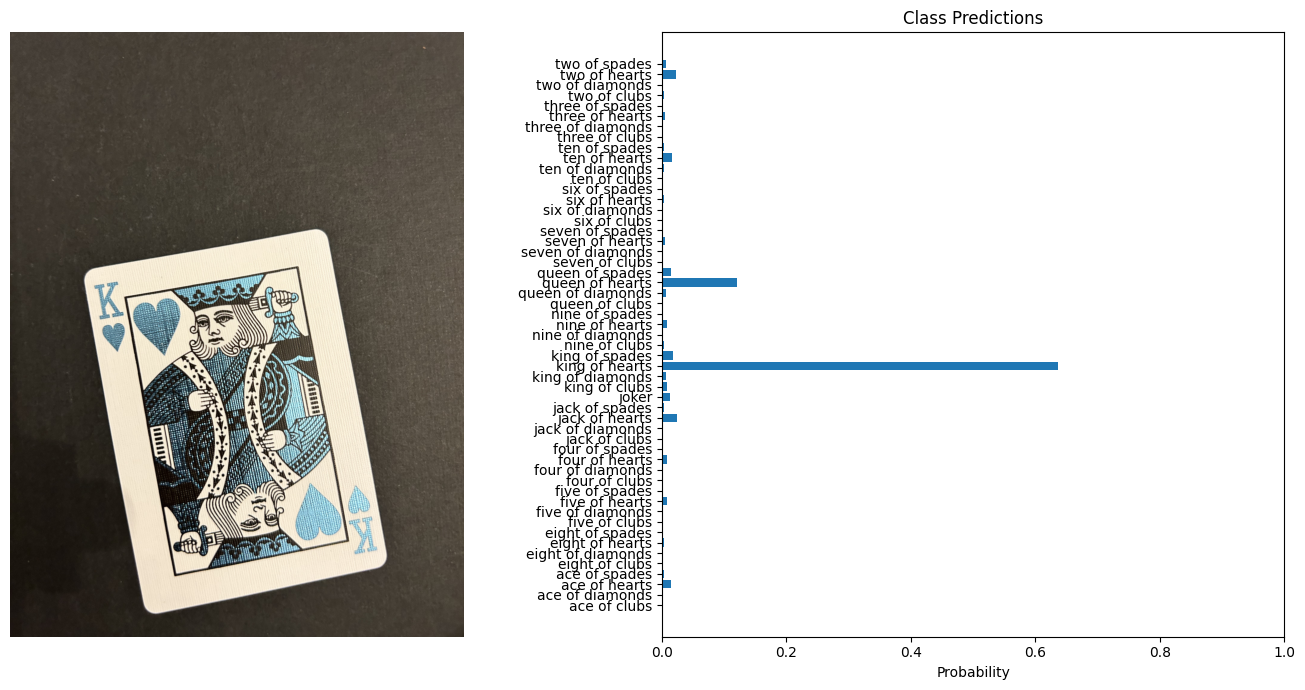

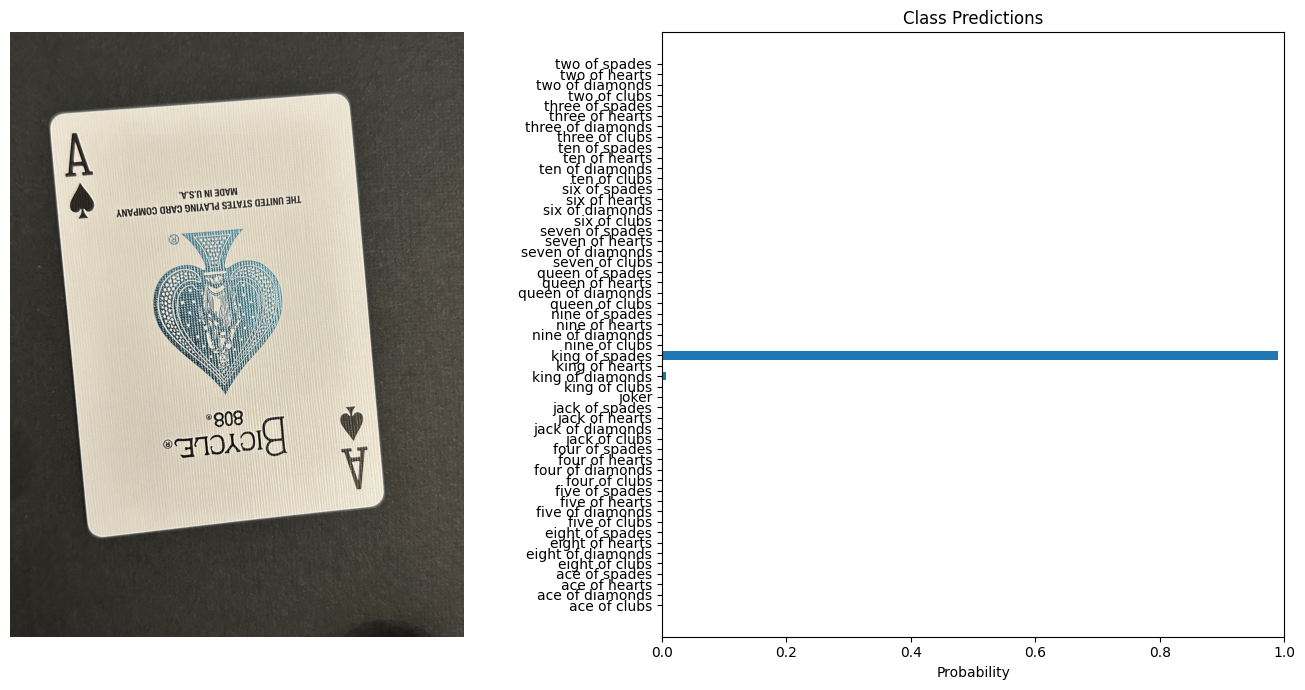

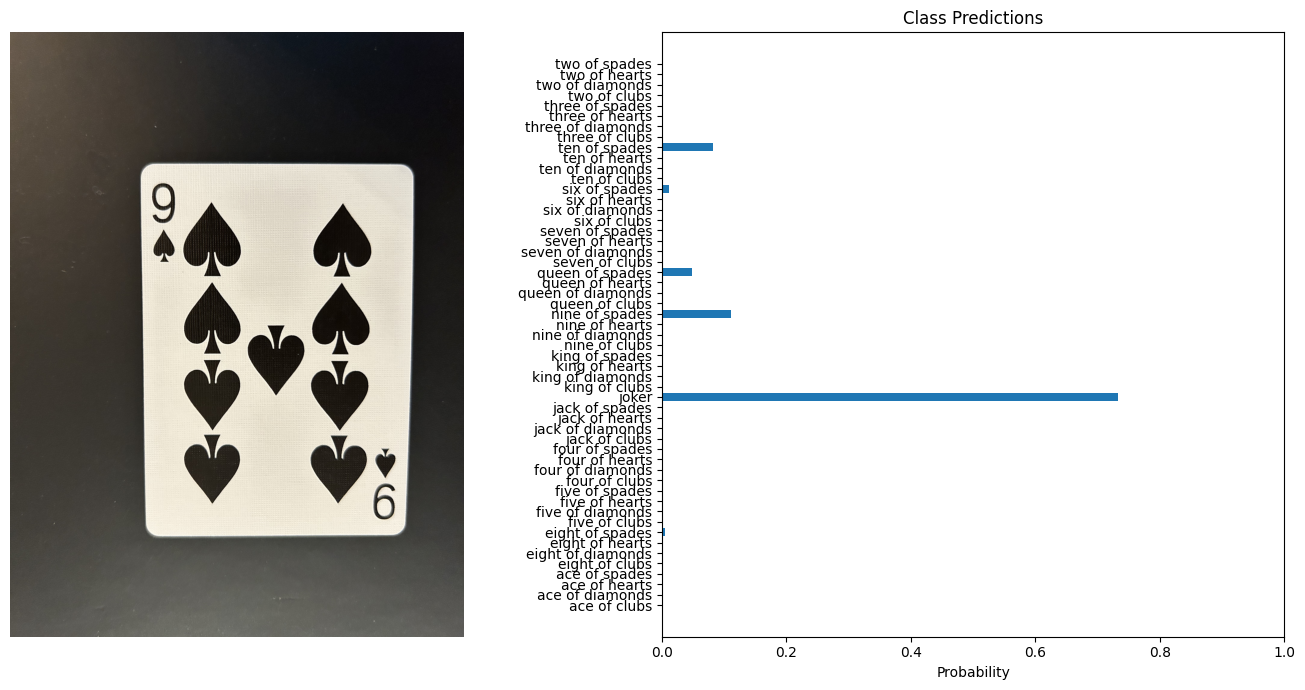

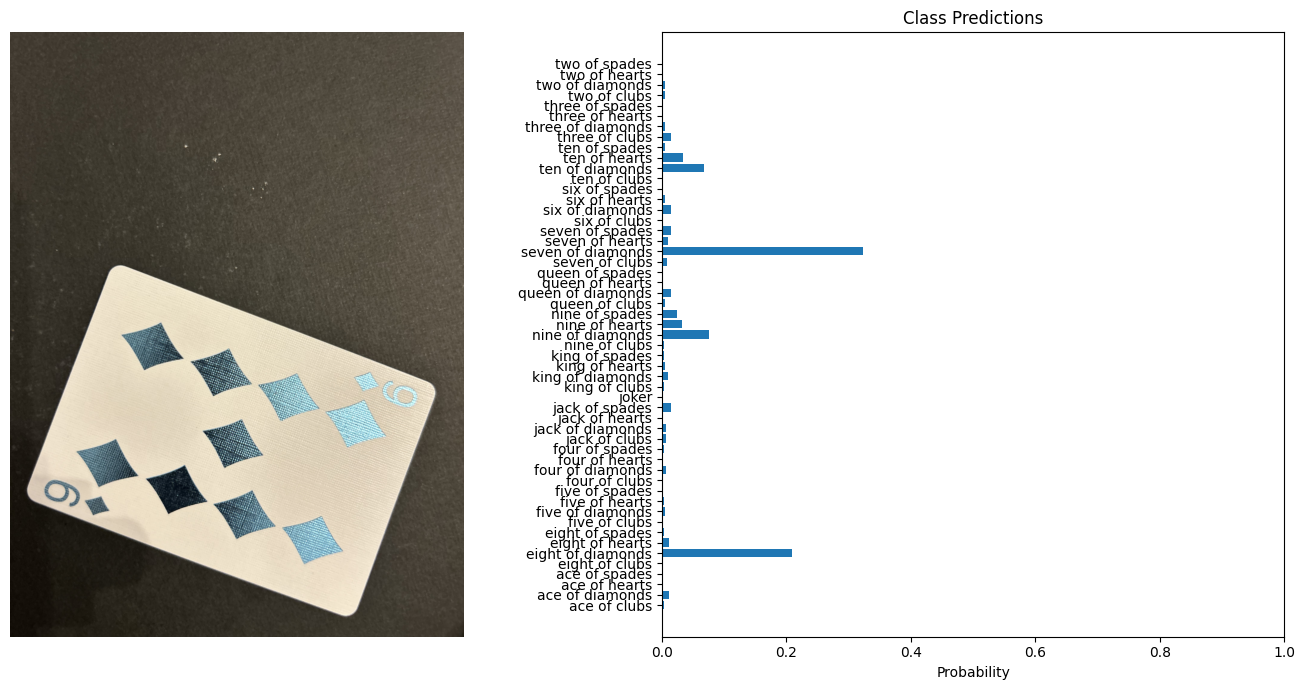

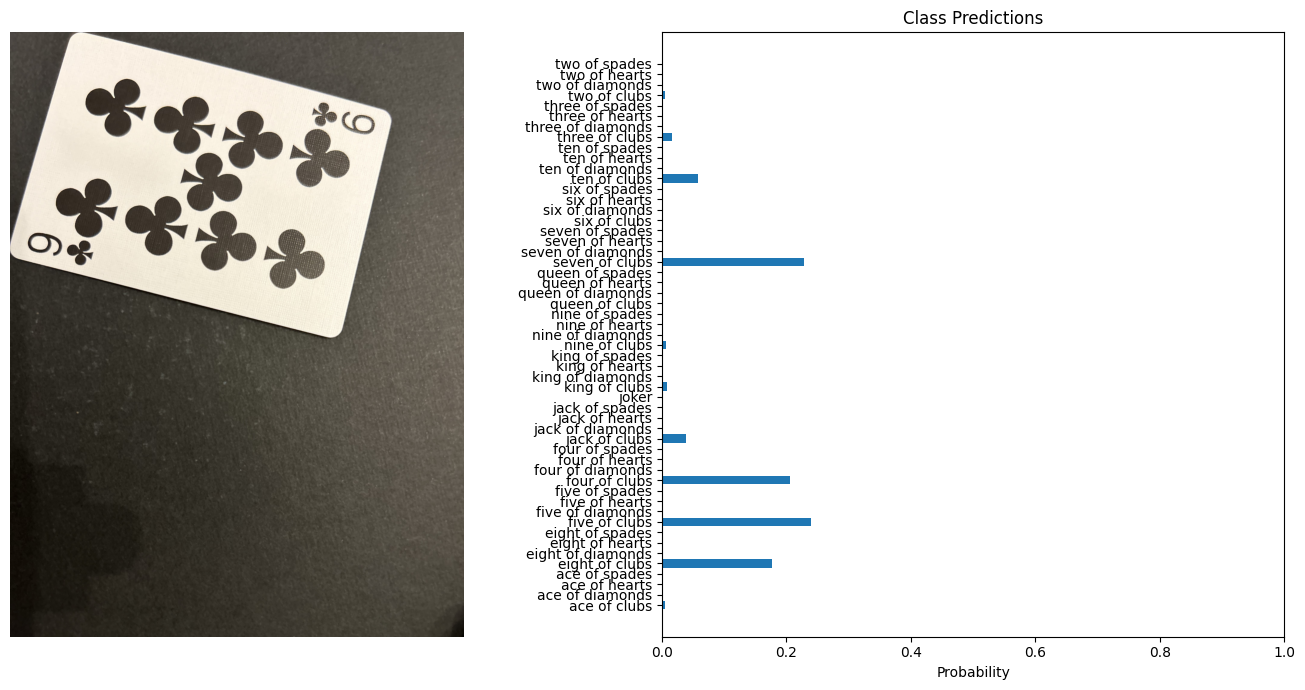

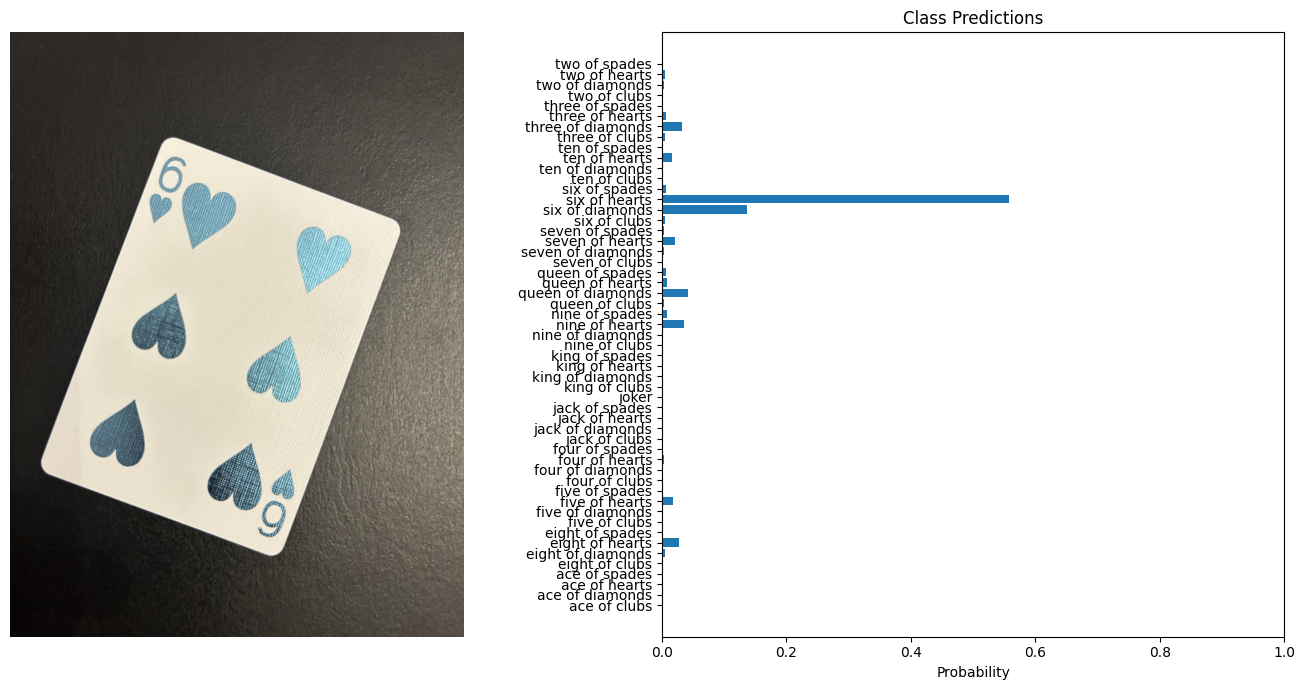

In [27]:
from glob import glob
test_images = glob(r'C:\Users\jobri\Documents\679\new_cards_data/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)